In [297]:
#import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
#nltk.download('stopwords')
#from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.cluster import KMeans
from collections import Counter
from scipy.sparse import hstack, csr_matrix

In [2]:
#define utility functions

#calculates the proportion of sentence words present in a given vocabulary
def vocab_percentage(vocab_counter, s):
    split = s.split()
    counter = Counter(split)
    both = counter & vocab_counter
    counts = 0
    for word in both.keys():
        counts += counter[word]
    return counts/len(split)

#calculates the AoA sum of sentence words
def AoA_sum(AoA_counter, s):
    split = s.split()
    counter = Counter(split)
    both = counter & AoA_counter
    AoA_sum = 0
    for word in both.keys():
        try:
            AoA_sum += AoA_word_dict[word]
        except:
            continue
    return AoA_sum

#split data and create text vectors
def split_vectorize(feature_list = ['original_text'], regex_pattern = r'\w{1,}', stop_words='english',
                   vocabulary = None):
    #75-25 train test split
    train_X, test_X, train_y, test_y = train_test_split(df[feature_list],df["label"], random_state = 0)
    
    #vectorize by count (only text vectors)
    count_vect = CountVectorizer(analyzer='word', token_pattern=regex_pattern, stop_words=stop_words, \
                                 vocabulary = vocabulary)
    count_vect.fit(train_X['original_text'])
    xtrain_count =  count_vect.transform(train_X['original_text'])
    xtest_count =  count_vect.transform(test_X['original_text'])
    #test = """
    #vectorize by tf-idf (only text vectors)
    tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=regex_pattern, stop_words=stop_words, \
                                 vocabulary = vocabulary)
    tfidf_vect.fit(train_X['original_text'])
    xtrain_tfidf =  tfidf_vect.transform(train_X['original_text'])
    xtest_tfidf =  tfidf_vect.transform(test_X['original_text'])
    
    #vectorize by tf-idf 2-grams and 3-grams (word level, only text vectors)
    tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=regex_pattern, ngram_range=(2,3), \
                                       stop_words=stop_words, vocabulary = vocabulary)
    tfidf_vect_ngram.fit(train_X['original_text'])
    xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_X['original_text'])
    xtest_tfidf_ngram =  tfidf_vect_ngram.transform(test_X['original_text'])

    #vectorize by tf-idf 2-grams and 3-grams (character level, only text vectors)
    tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', ngram_range=(2,3))                                     
    tfidf_vect_ngram_chars.fit(train_X['original_text'])
    xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_X['original_text']) 
    xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(test_X['original_text'])#"""
    
    return train_X, test_X, train_y, test_y, xtrain_count, xtest_count, xtrain_tfidf, xtest_tfidf, \
    xtrain_tfidf_ngram, xtest_tfidf_ngram, xtrain_tfidf_ngram_chars, xtest_tfidf_ngram_chars

#fits, predicts, and computes the accuracy score for our selected models
def fit_predict_score():
    
    uniform = DummyClassifier(strategy = 'uniform', random_state = 0).fit(xtrain_count, train_y)
    rand_dev_preds = uniform.predict(xtest_count)
    print('Random dummy accuracy:', accuracy_score(rand_dev_preds, test_y))

    most_frequent = DummyClassifier(strategy = 'most_frequent', random_state = 0).fit(xtrain_count, train_y)
    mf_dev_preds = most_frequent.predict(xtest_count)
    print('Most frequent dummy accuracy:',accuracy_score(mf_dev_preds, test_y), '\n')

    clf = LogisticRegression(random_state = 0, max_iter = 500, n_jobs = -1).fit(xtrain_count, train_y)
    lr_preds = clf.predict(xtest_count)
    print('LogisticRegression count accuracy:',accuracy_score(lr_preds, test_y))

    clf = LogisticRegression(random_state = 0, max_iter = 500, n_jobs = -1).fit(xtrain_tfidf, train_y)
    lr_preds = clf.predict(xtest_tfidf)
    print('LogisticRegression TF-IDF accuracy:',accuracy_score(lr_preds, test_y))

    clf = LogisticRegression(random_state = 0, max_iter = 500, n_jobs = -1).fit(xtrain_tfidf_ngram, train_y)
    lr_preds = clf.predict(xtest_tfidf_ngram)
    print('LogisticRegression TF-IDF n-gram accuracy:',accuracy_score(lr_preds, test_y))

    clf = LogisticRegression(random_state = 0, max_iter = 500, n_jobs = -1).fit(xtrain_tfidf_ngram_chars, train_y)
    lr_preds = clf.predict(xtest_tfidf_ngram_chars)
    print('LogisticRegression TF-IDF n-gram characters accuracy:',accuracy_score(lr_preds, test_y), '\n')

    multi_nb_count = MultinomialNB()
    multi_nb_count.fit(xtrain_count,train_y)
    prediction = multi_nb_count.predict(xtest_count)
    print('MultinomialNB count accuracy:',accuracy_score(prediction, test_y))

    multi_nb_tfidf = MultinomialNB()
    multi_nb_tfidf.fit(xtrain_tfidf,train_y)
    prediction = multi_nb_tfidf.predict(xtest_tfidf)
    print('MultinomialNB TF-IDF accuracy:',accuracy_score(prediction, test_y))

    multi_nb_tfidf_ngram = MultinomialNB()
    multi_nb_tfidf_ngram.fit(xtrain_tfidf_ngram,train_y)
    prediction = multi_nb_tfidf_ngram.predict(xtest_tfidf_ngram)
    print('MultinomialNB TF-IDF n-gram accuracy:',accuracy_score(prediction, test_y))

    multi_nb_tfidf_ngram_chars = MultinomialNB()
    multi_nb_tfidf_ngram_chars.fit(xtrain_tfidf_ngram_chars,train_y)
    prediction = multi_nb_tfidf_ngram_chars.predict(xtest_tfidf_ngram_chars)
    print('MultinomialNB TF-IDF n-gram characters accuracy:',accuracy_score(prediction, test_y), '\n')

    rf_clf_count = RandomForestClassifier(n_estimators = 50, max_depth = 15, random_state = 0, n_jobs = -1).fit(xtrain_count, train_y)
    rf_count_preds = rf_clf_count.predict(xtest_count)
    print('RandomForest count accuracy:',accuracy_score(rf_count_preds, test_y))
    
    rf_clf_tfidf = RandomForestClassifier(n_estimators = 50, max_depth = 15, random_state = 0, n_jobs = -1).fit(xtrain_tfidf, train_y)
    rf_tfidf_preds = rf_clf_tfidf.predict(xtest_tfidf)
    print('RandomForest TF-IDF accuracy:',accuracy_score(rf_tfidf_preds, test_y))
    
    rf_clf_tfidf_ngram = RandomForestClassifier(n_estimators = 50, max_depth = 15, random_state = 0, n_jobs = -1).fit(xtrain_tfidf_ngram, train_y)
    rf_tfidf_ngram_preds = rf_clf_tfidf_ngram.predict(xtest_tfidf_ngram)
    print('RandomForest TF-IDF n-gram accuracy:',accuracy_score(rf_tfidf_ngram_preds, test_y))
    
    rf_clf_tfidf_ngram_chars = RandomForestClassifier(n_estimators = 50, max_depth = 15, random_state = 0, n_jobs = -1).fit(xtrain_tfidf_ngram_chars, train_y)
    rf_tfidf_ngram_chars_preds = rf_clf_tfidf_ngram_chars.predict(xtest_tfidf_ngram_chars)
    print('RandomForest TF-IDF n-gram characters accuracy:',accuracy_score(rf_tfidf_ngram_chars_preds, test_y))

#adds feature to text vectors
def add_feature_to_matrix(feature):
    
    global xtrain_count, xtest_count, xtrain_tfidf, xtest_tfidf, xtrain_tfidf_ngram, xtest_tfidf_ngram, \
    xtrain_tfidf_ngram_chars, xtest_tfidf_ngram_chars
    
    xtrain_count = csr_matrix(hstack([xtrain_count, csr_matrix(train_X[feature]).T]))
    xtest_count = csr_matrix(hstack([xtest_count, csr_matrix(test_X[feature]).T]))

    xtrain_tfidf = csr_matrix(hstack([xtrain_tfidf, csr_matrix(train_X[feature]).T]))
    xtest_tfidf = csr_matrix(hstack([xtest_tfidf, csr_matrix(test_X[feature]).T]))

    xtrain_tfidf_ngram = csr_matrix(hstack([xtrain_tfidf_ngram, csr_matrix(train_X[feature]).T]))
    xtest_tfidf_ngram = csr_matrix(hstack([xtest_tfidf_ngram, csr_matrix(test_X[feature]).T]))

    xtrain_tfidf_ngram_chars = csr_matrix(hstack([xtrain_tfidf_ngram_chars, csr_matrix(train_X[feature]).T]))
    xtest_tfidf_ngram_chars = csr_matrix(hstack([xtest_tfidf_ngram_chars, csr_matrix(test_X[feature]).T]))

In [3]:
#read in necessary data
df = pd.read_csv("WikiLarge_Train.csv")
AoA = pd.read_csv('AoA_51715_words.csv', encoding = 'unicode_escape')

file = open('dale_chall.txt', 'r')
dc_vocab = []
for line in file:
    dc_vocab.append(line.strip())

In [4]:
#intial preprocessing

#proportion of sentence words in Dale Chall 3000 Word List
dc_counter = Counter(dc_vocab)
result = [vocab_percentage(dc_counter, s) for s in df['original_text']]
df['dc_proportion'] = result

#proportion of sentence words in AoA_51715_words
AoA_vocab = AoA['Word'].unique()
AoA_counter = Counter(AoA_vocab)
result = [vocab_percentage(AoA_counter, s) for s in df['original_text']]
df['AoA_proportion'] = result

#AoA sum of sentence words
AoA_word_dict = dict(zip(AoA.Word, AoA.AoA_Kup_lem))
AoA_counter = Counter(AoA_vocab)
result = [AoA_sum(AoA_counter, s) for s in df['original_text']]
df['AoA_sum'] = result
df['AoA_sum'] = df['AoA_sum'].fillna(0) #there are 7 records which have NaN for this field, not sure why

In [5]:
#let's see what we have
df.sample(5)

,original_text,label,dc_proportion,AoA_proportion,AoA_sum
104760,In modern mineralogy the term natron has come ...,1,0.551724,0.793103,135.83
297469,The 2006 â '' 07 Chicago Blackhawks season was...,0,0.304348,0.304348,24.83
402527,Mechanical bulls have been around for decades ...,0,0.580645,0.903226,148.12
410135,"Kennedy , George A. 1980 .",0,0.000000,0.000000,0.00
387336,The state capital is Tuxtla Gutiérrez . Other ...,0,0.240000,0.360000,46.00


In [6]:
#check class balance
df['label'].value_counts()

0    208384
1    208384
Name: label, dtype: int64

# Tokenize on word characters, remove stop words

In [7]:
train_X, test_X, train_y, test_y, xtrain_count, xtest_count, xtrain_tfidf, xtest_tfidf, xtrain_tfidf_ngram, \
xtest_tfidf_ngram, xtrain_tfidf_ngram_chars, xtest_tfidf_ngram_chars = split_vectorize()

In [8]:
fit_predict_score()

Random dummy accuracy: 0.4988770730958231
Most frequent dummy accuracy: 0.4982532248157248 

LogisticRegression count accuracy: 0.6581407401719902
LogisticRegression TF-IDF accuracy: 0.6628723894348895
LogisticRegression TF-IDF n-gram accuracy: 0.5452721898034398
LogisticRegression TF-IDF n-gram characters accuracy: 0.7064745853808354 

MultinomialNB count accuracy: 0.5757159858722358
MultinomialNB TF-IDF accuracy: 0.5769828777641277
MultinomialNB TF-IDF n-gram accuracy: 0.5105574324324325
MultinomialNB TF-IDF n-gram characters accuracy: 0.6310561271498771 

RandomForest count accuracy: 0.6214296683046683
RandomForest TF-IDF accuracy: 0.6262189035626535
RandomForest TF-IDF n-gram accuracy: 0.5389281326781327
RandomForest TF-IDF n-gram characters accuracy: 0.6858204084766585


# Tokenize on whitespace, remove stop words

In [9]:
train_X, test_X, train_y, test_y, xtrain_count, xtest_count, xtrain_tfidf, xtest_tfidf, xtrain_tfidf_ngram, \
xtest_tfidf_ngram, xtrain_tfidf_ngram_chars, xtest_tfidf_ngram_chars = split_vectorize(regex_pattern = r'\S*')

/sw/arcts/centos7/python3.8-anaconda/2021.05/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [''] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [10]:
fit_predict_score()

Random dummy accuracy: 0.4988770730958231
Most frequent dummy accuracy: 0.4982532248157248 

LogisticRegression count accuracy: 0.6793227886977887
LogisticRegression TF-IDF accuracy: 0.6861563267813268
LogisticRegression TF-IDF n-gram accuracy: 0.7055724047911548
LogisticRegression TF-IDF n-gram characters accuracy: 0.7064745853808354 

MultinomialNB count accuracy: 0.594700168918919
MultinomialNB TF-IDF accuracy: 0.5915809275184275
MultinomialNB TF-IDF n-gram accuracy: 0.620690648034398
MultinomialNB TF-IDF n-gram characters accuracy: 0.6310561271498771 

RandomForest count accuracy: 0.6443680896805897
RandomForest TF-IDF accuracy: 0.6555493703931204
RandomForest TF-IDF n-gram accuracy: 0.6688421375921376
RandomForest TF-IDF n-gram characters accuracy: 0.6858204084766585


# Tokenize on word characters, keep stop words

In [11]:
train_X, test_X, train_y, test_y, xtrain_count, xtest_count, xtrain_tfidf, xtest_tfidf, xtrain_tfidf_ngram, \
xtest_tfidf_ngram, xtrain_tfidf_ngram_chars, xtest_tfidf_ngram_chars = split_vectorize(stop_words = None)

In [12]:
fit_predict_score()

Random dummy accuracy: 0.4988770730958231
Most frequent dummy accuracy: 0.4982532248157248 

LogisticRegression count accuracy: 0.6743224047911548
LogisticRegression TF-IDF accuracy: 0.6853213298525799
LogisticRegression TF-IDF n-gram accuracy: 0.6590045300982801
LogisticRegression TF-IDF n-gram characters accuracy: 0.7064745853808354 

MultinomialNB count accuracy: 0.5947961455773956
MultinomialNB TF-IDF accuracy: 0.5950744778869779
MultinomialNB TF-IDF n-gram accuracy: 0.5754376535626535
MultinomialNB TF-IDF n-gram characters accuracy: 0.6310561271498771 

RandomForest count accuracy: 0.6400011517199017
RandomForest TF-IDF accuracy: 0.6480439957002457
RandomForest TF-IDF n-gram accuracy: 0.6019464066339066
RandomForest TF-IDF n-gram characters accuracy: 0.6858204084766585


# Tokenize on whitespace, keep stop words

In [13]:
train_X, test_X, train_y, test_y, xtrain_count, xtest_count, xtrain_tfidf, xtest_tfidf, xtrain_tfidf_ngram, \
xtest_tfidf_ngram, xtrain_tfidf_ngram_chars, xtest_tfidf_ngram_chars \
= split_vectorize(regex_pattern = r'\S*', stop_words = None)

In [14]:
fit_predict_score()

Random dummy accuracy: 0.4988770730958231
Most frequent dummy accuracy: 0.4982532248157248 

LogisticRegression count accuracy: 0.6912430896805897
LogisticRegression TF-IDF accuracy: 0.702923449017199
LogisticRegression TF-IDF n-gram accuracy: 0.7182989097051597
LogisticRegression TF-IDF n-gram characters accuracy: 0.7064745853808354 

MultinomialNB count accuracy: 0.6096149416461917
MultinomialNB TF-IDF accuracy: 0.6089623003685504
MultinomialNB TF-IDF n-gram accuracy: 0.6354710534398035
MultinomialNB TF-IDF n-gram characters accuracy: 0.6310561271498771 

RandomForest count accuracy: 0.6505681818181818
RandomForest TF-IDF accuracy: 0.657228961916462
RandomForest TF-IDF n-gram accuracy: 0.6626132524570024
RandomForest TF-IDF n-gram characters accuracy: 0.6858204084766585


# Tokenize on whitespace, vocabulary built on Dale Chall 3000 Word List

In [15]:
train_X, test_X, train_y, test_y, xtrain_count, xtest_count, xtrain_tfidf, xtest_tfidf, xtrain_tfidf_ngram, \
xtest_tfidf_ngram, xtrain_tfidf_ngram_chars, xtest_tfidf_ngram_chars \
= split_vectorize(regex_pattern = r'\S*', stop_words = None, vocabulary = set(dc_vocab))

In [16]:
fit_predict_score()

Random dummy accuracy: 0.4988770730958231
Most frequent dummy accuracy: 0.4982532248157248 

LogisticRegression count accuracy: 0.6511728347665847
LogisticRegression TF-IDF accuracy: 0.6512496160933661
LogisticRegression TF-IDF n-gram accuracy: 0.4982532248157248
LogisticRegression TF-IDF n-gram characters accuracy: 0.7064745853808354 

MultinomialNB count accuracy: 0.6187615171990172
MultinomialNB TF-IDF accuracy: 0.6200476044226044
MultinomialNB TF-IDF n-gram accuracy: 0.4982532248157248
MultinomialNB TF-IDF n-gram characters accuracy: 0.6310561271498771 

RandomForest count accuracy: 0.6377457002457002
RandomForest TF-IDF accuracy: 0.6379568488943489
RandomForest TF-IDF n-gram accuracy: 0.4982532248157248
RandomForest TF-IDF n-gram characters accuracy: 0.6858204084766585


# Adding non-text features
As tokenizing on whitespace and keeping stopwords appears to produce the highest accuracy scores for the logistic regression and random forest models, we will settle on this representation of the text.

We will now begin incorporating non-text features into the feature space.

In [17]:
#adding proportion of sentence words in Dale Chall 3000 Word List to feature space
train_X, test_X, train_y, test_y, xtrain_count, xtest_count, xtrain_tfidf, xtest_tfidf, xtrain_tfidf_ngram, \
xtest_tfidf_ngram, xtrain_tfidf_ngram_chars, xtest_tfidf_ngram_chars \
= split_vectorize(["original_text", 'dc_proportion'], regex_pattern = r'\S*', stop_words = None)

feature_list = ['dc_proportion']

for feature in feature_list:
    add_feature_to_matrix(feature)

In [18]:
fit_predict_score()

Random dummy accuracy: 0.4988770730958231
Most frequent dummy accuracy: 0.4982532248157248 

LogisticRegression count accuracy: 0.6941703777641277
LogisticRegression TF-IDF accuracy: 0.7028274723587223
LogisticRegression TF-IDF n-gram accuracy: 0.7176846590909091
LogisticRegression TF-IDF n-gram characters accuracy: 0.7062634367321867 

MultinomialNB count accuracy: 0.6113905098280098
MultinomialNB TF-IDF accuracy: 0.6094709766584766
MultinomialNB TF-IDF n-gram accuracy: 0.6361908783783784
MultinomialNB TF-IDF n-gram characters accuracy: 0.6317567567567568 

RandomForest count accuracy: 0.6532747235872236
RandomForest TF-IDF accuracy: 0.6657804821867321
RandomForest TF-IDF n-gram accuracy: 0.6645903716216216
RandomForest TF-IDF n-gram characters accuracy: 0.6865594287469288


That didn't seem to help much (in some cases, it hurt!).  We will now add the proportion of sentence words in the AoA dataset as well as the AoA sum for the entire sentence.

In [19]:
train_X, test_X, train_y, test_y, xtrain_count, xtest_count, xtrain_tfidf, xtest_tfidf, xtrain_tfidf_ngram, \
xtest_tfidf_ngram, xtrain_tfidf_ngram_chars, xtest_tfidf_ngram_chars \
= split_vectorize(["original_text", 'dc_proportion','AoA_proportion','AoA_sum'], regex_pattern = r'\S*', \
                  stop_words = None)

feature_list = ['dc_proportion', 'AoA_proportion', 'AoA_sum']

for feature in feature_list:
    add_feature_to_matrix(feature)

In [20]:
fit_predict_score()

Random dummy accuracy: 0.4988770730958231
Most frequent dummy accuracy: 0.4982532248157248 

LogisticRegression count accuracy: 0.7025011517199017
LogisticRegression TF-IDF accuracy: 0.7019732800982801
LogisticRegression TF-IDF n-gram accuracy: 0.7167824785012284
LogisticRegression TF-IDF n-gram characters accuracy: 0.7041423525798526 

MultinomialNB count accuracy: 0.6215736332923832
MultinomialNB TF-IDF accuracy: 0.6421990171990172
MultinomialNB TF-IDF n-gram accuracy: 0.6066780558968059
MultinomialNB TF-IDF n-gram characters accuracy: 0.6299044072481572 

RandomForest count accuracy: 0.6572481572481572
RandomForest TF-IDF accuracy: 0.6631507217444718
RandomForest TF-IDF n-gram accuracy: 0.6591101044226044
RandomForest TF-IDF n-gram characters accuracy: 0.6852157555282555


In [21]:
models = ['Random', 'Most Frequent', 'LR, count', 'LR, TF-IDF', 'LR, TF-IDF n-gram', \
         'LR, TF-IDF n-gram characters', 'MNB, count', 'MNB, TF-IDF', 'MNB, TF-IDF n-gram', \
         'MNB, TF-IDF n-gram characters', 'RF, count', 'RF, TF-IDF', 'RF, TF-IDF n-gram', \
         'RF, TF-IDF n-gram characters']

word_characters_no_stop = [0.49888, 0.49825, 0.65809, 0.66298, 0.54527, 0.70651, 0.57572, 0.57698, 0.51056, \
                          0.63106, 0.62143, 0.62622, 0.53893, 0.68582]

whitespace_no_stop = [0.49888, 0.49825, 0.68131, 0.68611, 0.70561, 0.70651, 0.59470, 0.59158, 0.62069, \
                     0.63106, 0.64437, 0.65555, 0.66884, 0.68582]

word_characters_w_stop = [0.49888, 0.49825, 0.67456, 0.68529, 0.65906, 0.70651, 0.59480, 0.59507, 0.57544, \
                          0.63106, 0.64000, 0.64804, 0.60195, 0.68582]

whitespace_w_stop = [0.49888, 0.49825, 0.69370, 0.70284, 0.71829, 0.70651, 0.60961, 0.60896, 0.63547, 0.63106, \
                     0.65057, 0.65723, 0.66261, 0.68582]

dc_3000 = [0.49888, 0.49825, 0.65119, 0.65132, 0.49825, 0.70651, 0.61876, 0.62005, 0.49825, 0.63106, 0.63775, \
          0.63796, 0.49825, 0.68582]

whitespace_w_stop_dc_prop = [0.49888, 0.49825, 0.69599, 0.70292, 0.71768, 0.70639, 0.61139, 0.60947, 0.63619, \
                             0.63176, 0.65327, 0.66578, 0.66459, 0.68656]

whitespace_w_stop_dc_prop_AoA = [0.49888, 0.49825, 0.70217, 0.70102, 0.71714, 0.70479, 0.62157, 0.64220, 0.60668, \
                                 0.62990, 0.65725, 0.66315, 0.65911, 0.68522]

results_df = pd.DataFrame(index = models)
results_df['wc w/o stop'] = word_characters_no_stop
results_df['ws w/o stop'] = whitespace_no_stop
results_df['wc w/ stop'] = word_characters_w_stop
results_df['ws w/ stop'] = whitespace_w_stop
results_df['DC_3000'] = dc_3000
results_df['ws w/ stop + dc_prop'] = whitespace_w_stop_dc_prop
results_df['ws w/ stop + dc_prop + AoA'] = whitespace_w_stop_dc_prop_AoA
results_df

,wc w/o stop,ws w/o stop,wc w/ stop,ws w/ stop,DC_3000,ws w/ stop + dc_prop,ws w/ stop + dc_prop + AoA
Random,0.49888,0.49888,0.49888,0.49888,0.49888,0.49888,0.49888
Most Frequent,0.49825,0.49825,0.49825,0.49825,0.49825,0.49825,0.49825
"LR, count",0.65809,0.68131,0.67456,0.69370,0.65119,0.69599,0.70217
"LR, TF-IDF",0.66298,0.68611,0.68529,0.70284,0.65132,0.70292,0.70102
"LR, TF-IDF n-gram",0.54527,0.70561,0.65906,0.71829,0.49825,0.71768,0.71714
"LR, TF-IDF n-gram characters",0.70651,0.70651,0.70651,0.70651,0.70651,0.70639,0.70479
"MNB, count",0.57572,0.59470,0.59480,0.60961,0.61876,0.61139,0.62157
"MNB, TF-IDF",0.57698,0.59158,0.59507,0.60896,0.62005,0.60947,0.64220
"MNB, TF-IDF n-gram",0.51056,0.62069,0.57544,0.63547,0.49825,0.63619,0.60668
"MNB, TF-IDF n-gram characters",0.63106,0.63106,0.63106,0.63106,0.63106,0.63176,0.62990


# Hyperparameter Tuning on Best Performing Model

In [317]:
train_X, test_X, train_y, test_y = train_test_split(df['original_text'],df["label"], random_state = 0)

tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\S*', ngram_range=(2,3))
tfidf_vect_ngram.fit(train_X)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_X)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(test_X)

lr = LogisticRegression(random_state = 0, max_iter = 500, n_jobs = -1)

In [28]:
param_grid = {'penalty': ['none', 'l2'],
             'C': [0.01, 0.1, 0.5, 1, 5, 10, 100]}
clf = GridSearchCV(lr, param_grid, refit = True, return_train_score = True, verbose = 4, n_jobs = -1)
clf.fit(xtrain_tfidf_ngram, train_y)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(estimator=LogisticRegression(max_iter=500, n_jobs=-1,
                                          random_state=0),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.5, 1, 5, 10, 100],
                         'penalty': ['none', 'l2']},
             return_train_score=True, verbose=4)

In [30]:
clf.cv_results_

{'mean_fit_time': array([275.26693296,  14.21525388, 262.4925355 ,  41.31083179,
        255.75405898,  64.75855055, 273.00667744,  92.51423426,
        263.81134562, 228.6466537 , 249.39479918, 293.43376818,
        248.26664948, 275.06712179]),
 'std_fit_time': array([22.6563189 ,  1.59043381, 22.71046167,  7.98381467, 15.20833003,
        10.15244157, 24.15270314,  9.70086136, 25.82200708, 20.30875537,
         8.52835537,  9.60591013,  8.99488536,  8.76217018]),
 'mean_score_time': array([0.09413919, 0.09909611, 0.07618752, 0.08789735, 0.08007979,
        0.05841455, 0.0524754 , 0.04995174, 0.05749531, 0.07349663,
        0.04624515, 0.06951685, 0.05898142, 0.04457188]),
 'std_score_time': array([0.02663067, 0.03388054, 0.0554621 , 0.04321677, 0.0265382 ,
        0.0202193 , 0.0082102 , 0.00518296, 0.02119367, 0.03025851,
        0.00065254, 0.01950826, 0.02978657, 0.00206374]),
 'param_C': masked_array(data=[0.01, 0.01, 0.1, 0.1, 0.5, 0.5, 1, 1, 5, 5, 10, 10,
                    1

In [31]:
clf.best_estimator_

LogisticRegression(C=1, max_iter=500, n_jobs=-1, random_state=0)

In [32]:
clf.best_score_

0.712991406907182

In [33]:
clf.best_params_

{'C': 1, 'penalty': 'l2'}

Default settings seem to produce the best results.

# Model Analysis
Training the model with optimal parameters and analyze.

In [318]:
lr.fit(xtrain_tfidf_ngram, train_y)

LogisticRegression(max_iter=500, n_jobs=-1, random_state=0)

In [ ]:
absolute_coef = np.absolute(lr.coef_)
index_positions = absolute_coef.argsort()[0][-20:]
top_20_coef = np.flip(lr.coef_[0][index_positions])

feature_names = tfidf_vect_ngram.get_feature_names()
top_20_names = np.flip([feature_names[i] for i in index_positions])

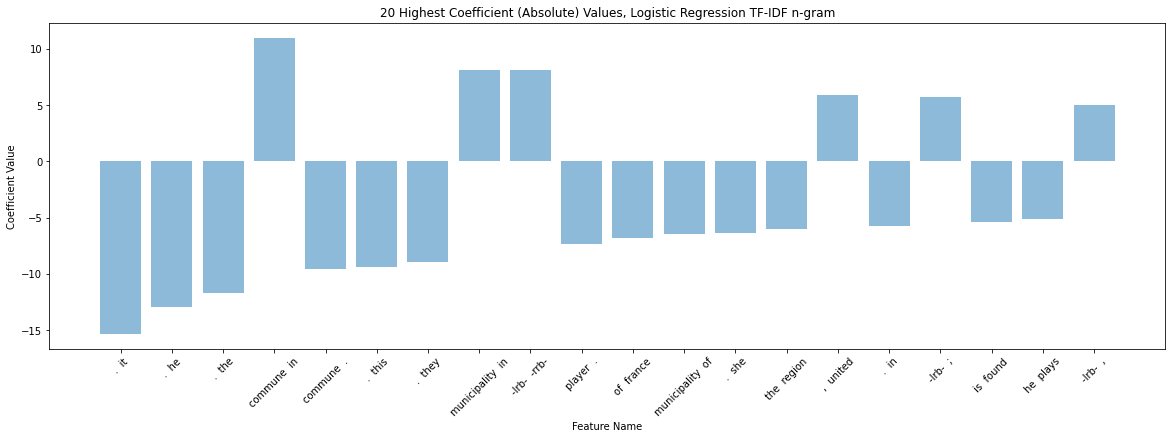

In [283]:
x = np.arange(len(top_20_names))
plt.figure(figsize = (20,6))
plt.bar(x, top_20_coef, align='center', alpha=0.5)
plt.xticks(x, top_20_names, rotation = 45)
plt.ylabel('Coefficient Value')
plt.xlabel('Feature Name')
plt.title('20 Highest Coefficient (Absolute) Values, Logistic Regression TF-IDF n-gram')
plt.show();

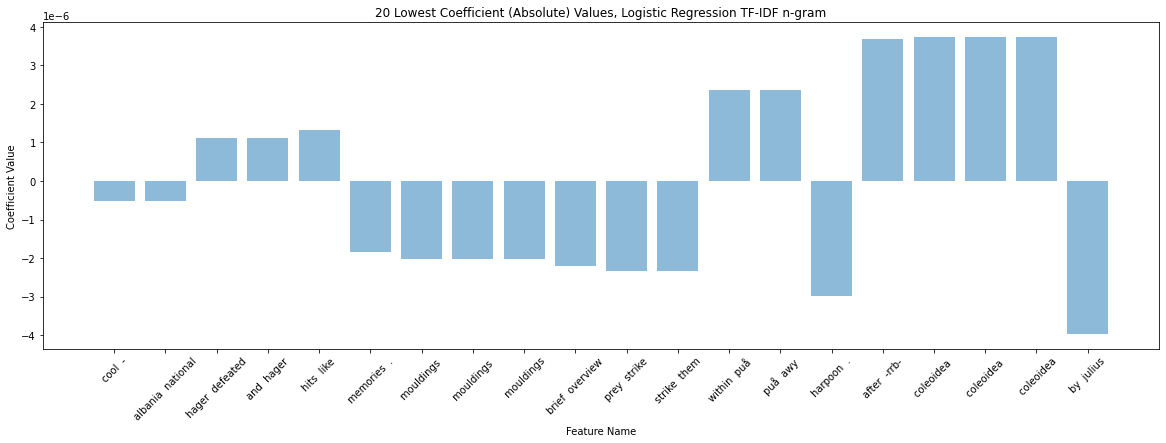

In [284]:
index_positions = absolute_coef.argsort()[0][:20]
bottom_20_coef = lr.coef_[0][index_positions]

bottom_20_names = [feature_names[i] for i in index_positions]
                   
x = np.arange(len(bottom_20_names))
plt.figure(figsize = (20,6))
plt.bar(x, bottom_20_coef, align='center', alpha=0.5)
plt.xticks(x, bottom_20_names, rotation = 45)
plt.ylabel('Coefficient Value')
plt.xlabel('Feature Name')
plt.title('20 Lowest Coefficient (Absolute) Values, Logistic Regression TF-IDF n-gram')
plt.show();

In [248]:
Cs = [0.01, 0.1, 0.5, 1, 5, 10, 100]
none_accuracy = []
l2_accuracy = []

for C in Cs:
    lr = LogisticRegression(random_state = 0, max_iter = 500, n_jobs = -1, C = C)
    lr.fit(xtrain_tfidf_ngram, train_y)
    preds = lr.predict(xtest_tfidf_ngram)
    print('Penalty = l2, C = {}, accuracy: '.format(C), accuracy_score(preds, test_y))
    l2_accuracy.append(accuracy_score(preds, test_y))
    
lr = LogisticRegression(random_state = 0, max_iter = 500, n_jobs = -1, penalty = 'none')
lr.fit(xtrain_tfidf_ngram, train_y)
preds = lr.predict(xtest_tfidf_ngram)
print('Penalty = none, accuracy: ', accuracy_score(preds, test_y))
none_accuracy.append(accuracy_score(preds, test_y))

Penalty = l2, C = 0.01, accuracy:  0.667565648034398
Penalty = l2, C = 0.1, accuracy:  0.699737023955774
Penalty = l2, C = 0.5, accuracy:  0.7165905251842751
Penalty = l2, C = 1, accuracy:  0.718289312039312
Penalty = l2, C = 5, accuracy:  0.7078182585995086
Penalty = l2, C = 10, accuracy:  0.702146038083538
Penalty = l2, C = 100, accuracy:  0.6918477426289926
Penalty = none, accuracy:  0.6738233261670762


Text(0.5, 1.0, 'Logistic Regression TF-IDF n-gram Sensitivity Plot')

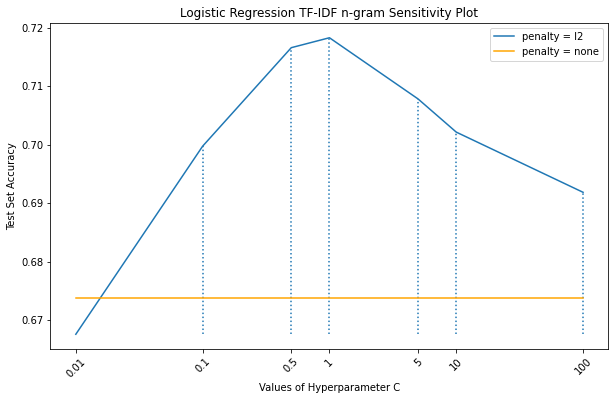

In [288]:
none_accuracy = [0.6738233261670762, 0.6738233261670762, 0.6738233261670762, 0.6738233261670762, \
                0.6738233261670762, 0.6738233261670762, 0.6738233261670762]

plt.figure(figsize = (10,6))
plt.plot(np.log(Cs), l2_accuracy, label = 'penalty = l2')
plt.plot(np.log(Cs), none_accuracy, color = 'orange', label = 'penalty = none')
plt.xticks([np.log(Cs[0]), np.log(Cs[1]), np.log(Cs[2]), np.log(Cs[3]), np.log(Cs[4]), np.log(Cs[5]), \
           np.log(Cs[6])], ['0.01', '0.1', '0.5', '1', '5', '10', '100'], rotation = 45)
plt.vlines([np.log(Cs[0]), np.log(Cs[1]), np.log(Cs[2]), np.log(Cs[3]), np.log(Cs[4]), np.log(Cs[5]), \
            np.log(Cs[6])], 0.667565648034398, l2_accuracy, linestyles = 'dotted')
plt.legend()
plt.xlabel('Values of Hyperparameter C')
plt.ylabel('Test Set Accuracy')
plt.title('Logistic Regression TF-IDF n-gram Sensitivity Plot')

In [319]:
train_preds = lr.predict(xtrain_tfidf_ngram)
accuracy_score(train_preds, train_y)

0.8077523546273546

In [411]:
test_preds = lr.predict(xtest_tfidf_ngram)

test_df = pd.DataFrame(columns = ['original_text', 'predicted_label', 'true_label'], index = test_X.index)
test_df['original_text'] = test_X
test_df['predicted_label'] = test_preds
test_df['true_label'] = test_y
predtrue_acttrue = test_df[(test_df['predicted_label'] == 1) & (test_df['true_label'] == 1)]
predfalse_actfalse = test_df[(test_df['predicted_label'] == 0) & (test_df['true_label'] == 0)]
predtrue_actfalse = test_df[(test_df['predicted_label'] == 1) & (test_df['true_label'] == 0)]
predfalse_acttrue = test_df[(test_df['predicted_label'] == 0) & (test_df['true_label'] == 1)]

cross_df = pd.DataFrame(columns = ['Predicted True', 'Predicted False'], \
                        index = ['Actually True', 'Actually False'])

cross_df['Predicted True'] = [len(predtrue_acttrue)/len(test_df), len(predtrue_actfalse)/len(test_df)]
cross_df['Predicted False'] = [len(predfalse_acttrue)/len(test_df), len(predfalse_actfalse)/len(test_df)]

print('Precision:', (len(predtrue_acttrue)/(len(predtrue_acttrue) + len(predtrue_actfalse))))
print('Recall: ', (len(predtrue_acttrue)/(len(predtrue_acttrue) + len(predfalse_acttrue))))

print(len(predtrue_acttrue), len(predfalse_actfalse), len(predtrue_actfalse), len(predfalse_acttrue))

cross_df

Precision: 0.7125375458894204
Recall:  0.735108458625043
38430 36410 15504 13848


,Predicted True,Predicted False
Actually True,0.368838,0.132908
Actually False,0.148802,0.349451


Here we see that false positives (predicted true, actually false) and false negatives (predicted false, actually true) occur in similar proportions.

In [462]:
coef = lr.coef_
                   
top_coef_index_positions = absolute_coef.argsort()[0][-50:]
bottom_coef_index_positions = absolute_coef.argsort()[0][:50]

tp_df = test_df.reset_index()
tp_df = tp_df[(tp_df['predicted_label'] == 1) & (tp_df['true_label'] == 1)]
tp_indices = tp_df.index
tp_vecs = xtest_tfidf_ngram[tp_indices]

fp_df = test_df.reset_index()
fp_df = fp_df[(fp_df['predicted_label'] == 1) & (fp_df['true_label'] == 0)]
fp_indices = fp_df.index
fp_vecs = xtest_tfidf_ngram[fp_indices]

tn_df = test_df.reset_index()
tn_df = tn_df[(tn_df['predicted_label'] == 0) & (tn_df['true_label'] == 0)]
tn_indices = tn_df.index
tn_vecs = xtest_tfidf_ngram[tn_indices]

fn_df = test_df.reset_index()
fn_df = fn_df[(fn_df['predicted_label'] == 0) & (fn_df['true_label'] == 1)]
fn_indices = fn_df.index
fn_vecs = xtest_tfidf_ngram[fn_indices]

print(lr.decision_function(tp_vecs).mean())
print(lr.decision_function(fp_vecs).mean())
print(lr.decision_function(tn_vecs).mean())
print(lr.decision_function(fn_vecs).mean())

1.2250554123513577
0.6692939196540306
-1.30437447714933
-0.5945541805754706


In [468]:
top_pos_coef = coef[0][coef.argsort()[0][-50:]]
top_pos_index = coef.argsort()[0][-50:]
top_pos_features = [feature_names[i] for i in top_pos_index]

top_neg_coef = coef[0][coef.argsort()[0][:50]]
top_neg_index = coef.argsort()[0][:50]
top_neg_features = [feature_names[i] for i in top_neg_index]

tp_mean_coef = tp_vecs[:, top_pos_index].mean(axis = 0).mean(), tp_vecs[:, top_neg_index].mean(axis = 0).mean()
fp_mean_coef = fp_vecs[:, top_pos_index].mean(axis = 0).mean(), fp_vecs[:, top_neg_index].mean(axis = 0).mean()
tn_mean_coef = tn_vecs[:, top_pos_index].mean(axis = 0).mean(), tn_vecs[:, top_neg_index].mean(axis = 0).mean()
fn_mean_coef = fn_vecs[:, top_pos_index].mean(axis = 0).mean(), fn_vecs[:, top_neg_index].mean(axis = 0).mean()

print(tp_mean_coef, tp_mean_coef[0]/tp_mean_coef[1])
print(fp_mean_coef, fp_mean_coef[0]/fp_mean_coef[1])
print(tn_mean_coef, tn_mean_coef[0]/tn_mean_coef[1])
print(fn_mean_coef, fn_mean_coef[0]/fn_mean_coef[1])

(0.00419416999650816, 0.0010779841759631583) 3.8907528422304987
(0.003137075416544481, 0.0010391935041179836) 3.0187596478550702
(0.0017546293105513767, 0.002598844017529873) 0.6751576080426335
(0.0017581471494194415, 0.0014154968794652823) 1.2420706643193722


# Clustering

In [156]:
#add highest probability topics from LDA and NMF for 10 components and 20 components each
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\S*')
tf_documents = count_vect.fit_transform(df['original_text'])

lda_20 = LatentDirichletAllocation(n_components = 20, random_state = 0, n_jobs = -1)
topic_vecs = lda_20.fit_transform(tf_documents)
lda_20_feature = np.argmax(topic_vecs, axis = 1)
df['lda_20'] = lda_20_feature

lda_10 = LatentDirichletAllocation(n_components = 10, random_state = 0, n_jobs = -1)
topic_vecs = lda_10.fit_transform(tf_documents)
lda_10_feature = np.argmax(topic_vecs, axis = 1)
df['lda_10'] = lda_10_feature

nmf_10 = NMF(n_components = 10, random_state = 0, init = "nndsvd")
W_10 = nmf_10.fit_transform(tf_documents)
H_10 = nmf_10.components_
nmf_10_feature = np.argmax(W_10, axis = 1)
df['nmf_10'] = lda_10_feature

nmf_20 = NMF(n_components = 20, random_state = 0, init = "nndsvd")
W_20 = nmf_20.fit_transform(tf_documents)
H_20 = nmf_20.components_
nmf_20_feature = np.argmax(W_20, axis = 1)
df['nmf_20'] = lda_20_feature

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [157]:
#add predicted cluster labels from K-means with K = 10 and K = 20
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\S*')
tfidf_documents = tfidf_vect.fit_transform(df['original_text'])

kmeans_10 = KMeans(n_clusters = 10, random_state = 0)
kmeans_10.fit(tfidf_documents)
kmeans_10_feature = kmeans_10.labels_
df['kmeans_10'] = kmeans_10_feature

kmeans_20 = KMeans(n_clusters = 20, random_state = 0)
kmeans_20.fit(tfidf_documents)
kmeans_20_feature = kmeans_20.labels_
df['kmeans_20'] = kmeans_20_feature

In [174]:
feature_list = ["original_text", 'dc_proportion', 'AoA_proportion', 'lda_10', 'lda_20', 'nmf_10', 'nmf_20', \
    'kmeans_10', 'kmeans_20']

train_X, test_X, train_y, test_y, xtrain_count, xtest_count, xtrain_tfidf, xtest_tfidf, xtrain_tfidf_ngram, \
xtest_tfidf_ngram, xtrain_tfidf_ngram_chars, xtest_tfidf_ngram_chars \
= split_vectorize(feature_list, regex_pattern = r'\S*', stop_words = None)

In [175]:
for feature in feature_list[1:]:
    add_feature_to_matrix(feature)

In [176]:
clf = LogisticRegression(random_state = 0, max_iter = 500, n_jobs = -1).fit(xtrain_count, train_y)
lr_preds = clf.predict(xtest_count)
print('LogisticRegression count accuracy:',accuracy_score(lr_preds, test_y))

clf = LogisticRegression(random_state = 0, max_iter = 500, n_jobs = -1).fit(xtrain_tfidf, train_y)
lr_preds = clf.predict(xtest_tfidf)
print('LogisticRegression TF-IDF accuracy:',accuracy_score(lr_preds, test_y))

clf = LogisticRegression(random_state = 0, max_iter = 500, n_jobs = -1).fit(xtrain_tfidf_ngram, train_y)
lr_preds = clf.predict(xtest_tfidf_ngram)
print('LogisticRegression TF-IDF n-gram accuracy:',accuracy_score(lr_preds, test_y))

clf = LogisticRegression(random_state = 0, max_iter = 500, n_jobs = -1).fit(xtrain_tfidf_ngram_chars, train_y)
lr_preds = clf.predict(xtest_tfidf_ngram_chars)
print('LogisticRegression TF-IDF n-gram characters accuracy:',accuracy_score(lr_preds, test_y), '\n')

LogisticRegression count accuracy: 0.6989500153562653
LogisticRegression TF-IDF accuracy: 0.7022516124078624
LogisticRegression TF-IDF n-gram accuracy: 0.7105823863636364
LogisticRegression TF-IDF n-gram characters accuracy: 0.7032209766584766 



In [290]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\S*')
tfidf_documents = tfidf_vect.fit_transform(df['original_text'])

In [296]:
inertia_values = []
labels = []

for k in range(2,21):
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(tfidf_documents)
    labels.append(kmeans.labels_)
    inertia_values.append(kmeans.inertia_)

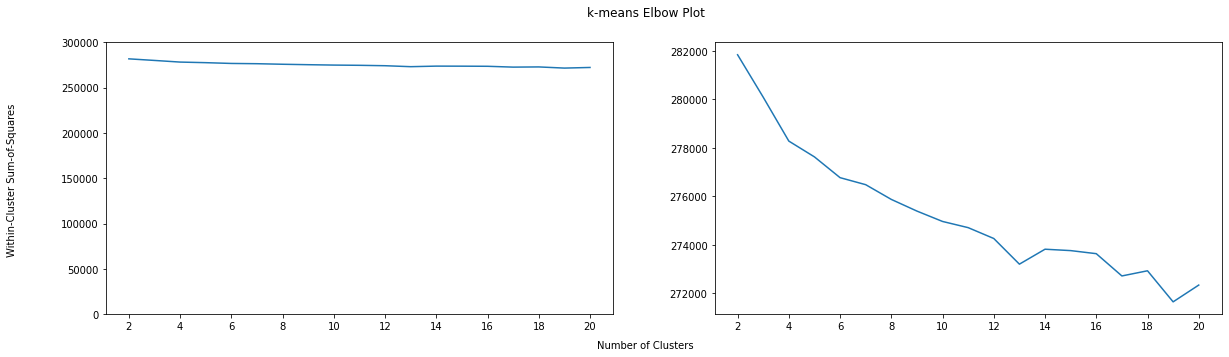

In [298]:
x = np.arange(2,21)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.text(0.06, 0.5, 'Within-Cluster Sum-of-Squares', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Number of Clusters', ha='center', va='center')
fig.set_size_inches(20, 5)

ax1.plot(x, inertia_values)
ax1.set_ylim([0, 300000])
ax2.plot(x, inertia_values)
ax1.set_xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
ax2.set_xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
fig.suptitle('k-means Elbow Plot');

In [306]:
silhouette_scores = []
for i in range(0,19):
    silhouette_scores.append(silhouette_score(tfidf_documents, labels[i], sample_size = 10000))

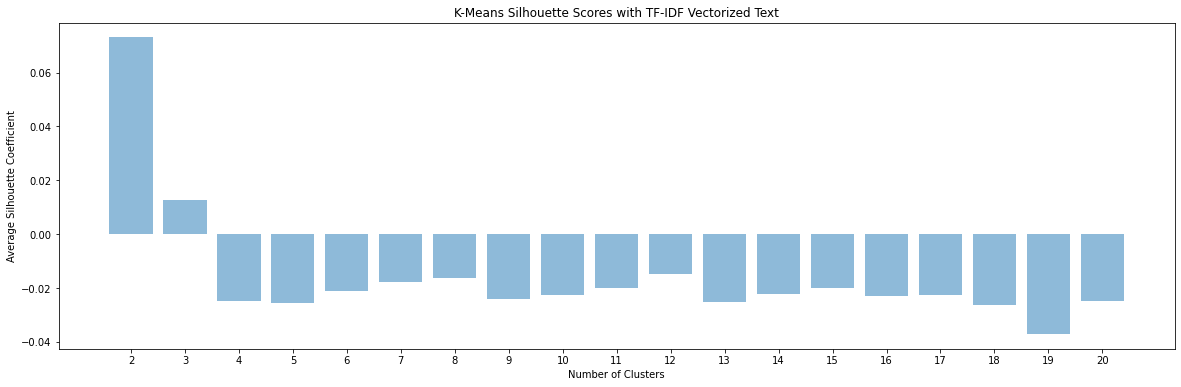

In [311]:
plt.figure(figsize = (20,6))
plt.bar(range(2,21), silhouette_scores, align='center', alpha=0.5)
plt.xticks(x)
plt.ylabel('Average Silhouette Coefficient')
plt.xlabel('Number of Clusters')
plt.title('K-Means Silhouette Scores with TF-IDF Vectorized Text')
plt.show();